# Creating word clouds

The first half of this notebook is just recreating conditions that were set up in [index.ipynb](./index.ipynb)

<a href='#Word-Clouds'><b>Click here to skip to the word cloud section.</b></a>

In [1]:
# Imports

import numpy as np
import pandas as pd

from nltk import FreqDist
from nltk.corpus import stopwords
import spacy

from sklearn.model_selection import train_test_split

import re
from collections import OrderedDict
import itertools
import string

from wordcloud import WordCloud, get_single_color_func

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 100
seed = 55
np.random.seed(seed)

## Data Preparation <a name="data_prep"></a>

The dataset used in this notebook was compiled by me in several other notebooks. See the [compile_and_filter_dataset](./compile_and_filter_dataset/) folder in this repository for the detailed process of how the data was collected.

### Read in final dataset, containing reddit comments and IMDb scores.

In [2]:
df = pd.read_csv('./data/data_final.csv')

### "Imploding" the dataframe

Currently, each comment is its own row, giving the dataset over 70,000 rows.

In reality, each of these comments corresponds to one of about 900 movies.

That's how I'm going to be dealing with this data from now own, so I will compress all the comments into lists.

In [3]:
comments_imploded = df.groupby('id')['comments'].agg(list)

In [4]:
df = df.drop_duplicates(subset='id').drop(columns=['comments'])
df = df.join(comments_imploded, on='id')
df['n_comments'] = df['comments'].apply(len)

### Combine main dataset with sentiment dataset

#### Where did the sentiment scores come from?

The sentiment dataframe was a last minute add-on in order to have feature-engineered sentiment labels for the Reddit comments I'm using.

My documentation of how I got these scores is [here](./compile_and_filter_dataset/5_get_sentiments.ipynb). That data was collected in a separate notebook that was run on Google Colab for its cloud GPU capability.

I used the Huggingface Transformers, along with a commonly used NLP model in order to get, for each movie, the proportion of positive, negative, and neutral comments.

In [5]:
sentiments = pd.read_csv("./data/reddit_movie_sentiments.csv")

In [6]:
index_df = df.index

df = pd.merge(
    left=df,
    right=sentiments.drop(columns=['title', 'ntrl_norm']), # (merging only positive and negative sentiments)
    how='inner',
    on='id'
)

df.index = index_df

### Visualizing the distribution of the target variable `averageRating`

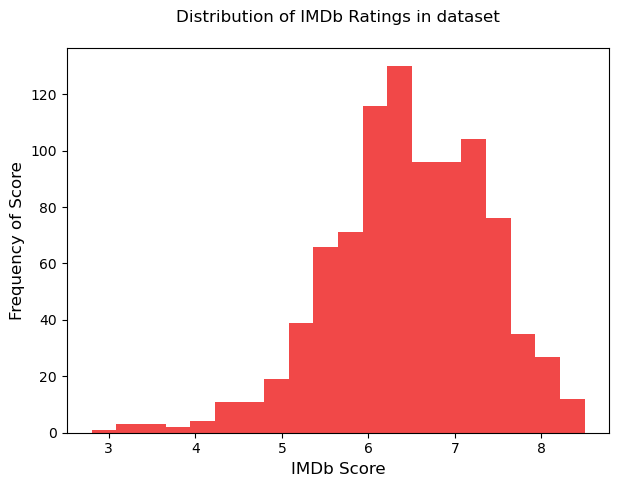

In [7]:
fig, ax = plt.subplots(figsize=(7,5))
df['averageRating'].hist(ax=ax, color='#f14848', bins=20, grid=False)
ax.set_title('Distribution of IMDb Ratings in dataset\n')
ax.set_xlabel('IMDb Score', size=12),
ax.set_ylabel('Frequency of Score', size=12)
fig.set_facecolor('white')
# plt.savefig('./images/IMDb_distribution.png', dpi=500)

In [8]:
df['averageRating'].describe()

count    922.000000
mean       6.471909
std        0.893870
min        2.800000
25%        6.000000
50%        6.500000
75%        7.100000
max        8.500000
Name: averageRating, dtype: float64

### Train-Test Split

In [9]:
features = df.drop(columns=['averageRating'])
target = df['averageRating']

X_train: Used for training the model and engineering features

X_val: Used for selecting a model

X_test: Used to score the final model

In [10]:
# Splitting the full dataset into training and testing data

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=seed
)

# Splitting off a validation set

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=.5, random_state=seed
)

### Cleaning and tokenizing comments

In [11]:
def clean_comments(comments_list):
    
    # Make everything lowercase
    cleaned = [comment.lower() for comment in comments_list]

    # Remove excessive white space and newlines
    cleaned = [comment.replace("\n", " ") for comment in cleaned]
    cleaned = [re.sub(pattern=r' {2,}', repl=' ', string=comment) for comment in cleaned]

    # Ensure apostrophes and quotation marks are consistent
    cleaned = [re.sub(r"’|‘", repl="'", string=comment) for comment in cleaned]
    cleaned = [re.sub(r"“|”", repl='"', string=comment) for comment in cleaned]
    
    return cleaned

In [12]:
X_train['comments'] = X_train['comments'].apply(clean_comments)

In [13]:
# Preview 

X_train.sample(5)['comments']

53296    ["luke skywalker projecting a force ghost across the galaxy to fuck with kylo ren" is the level ...
38838    [oh no bryson look out! oh my god, he's got airpods in, he can't hear us! oh fuck!, the pacing o...
6652     [this is a great example of a straightforward, formulaic movie elevated by \*excellent\* perform...
24543    [the sister's reaction to the email annoyed the shit out of me. you and your sister are supposed...
1473     ["what were you thinking" "you told me not to think!" fucking 10/10, very impressed with the way...
Name: comments, dtype: object

#### Why not remove punctuation?

Removing punctuation is a common step in cleaning text for NLP. I'm choosing not to yet since I plan to lemmatize words and extract part of speech tags. Doing so requires keeping grammatical context in the text, which would be lost if I removed punctuation at this point. Punctuation will be removed in a future step.

#### Setting up a tokenizer with SpaCy

In [14]:
# Disabling certain components to keep it light

nlp = spacy.load(
    "en_core_web_sm",
    disable=[
        "ner", "textcat", "custom",
        "entity_linker", "entity_linker",
        "textcat_multilabel", "transformer"
    ]
    )

#### New column: Converting each reddit discussion into a list of SpaCy docs. Each doc is a comment.

In [15]:
# This cell can take over 7 minutes to run

X_train['spacy_comments'] = X_train['comments'].apply(lambda x: list(nlp.pipe(x)))

#### Tokenizing

#### I plan to make multiple tokenized versions of each comment.

* Basic version: Any word with at least two letters. Strips the symbols for hashtags (#) and mentions(@)
* Basic version, excluding stop words
* Lemmatized version of basic version
* Lemmatized version of basic version, exluding stop words.

In [16]:
condition = lambda x: all([x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct])

In [17]:
def spacy_tokenize(list_of_docs):
    """
    Takes in a list of SpaCy documents.
    Converts them into one giant list of tokens as strings.
    Omits punctuation, non-ASCII characters, digits, URLs.
    """
    token_mask = \
        lambda x: all(
            [x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct]
            )
    tokens_by_doc = [[t.text for t in doc if token_mask(t)] for doc in list_of_docs]
    tokens_all_together = list(itertools.chain.from_iterable(tokens_by_doc))
    return tokens_all_together

In [18]:
X_train['tokens'] = X_train['spacy_comments'].apply(spacy_tokenize)

In [19]:
# X_train.head()

#### Stop words

To make a comprehensive list of stop words, I will combine the default lists from the NLTK and SpaCy libraries.

In [20]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
punct = list(string.punctuation)
stopword_list = list(set(sw_spacy + sw_nltk + punct))

In [21]:
len(stopword_list)

414

Are there any other other words I should include in stop words?

C:\Users\zshoo\AppData\Local\Temp\ipykernel_28120\4173814566.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


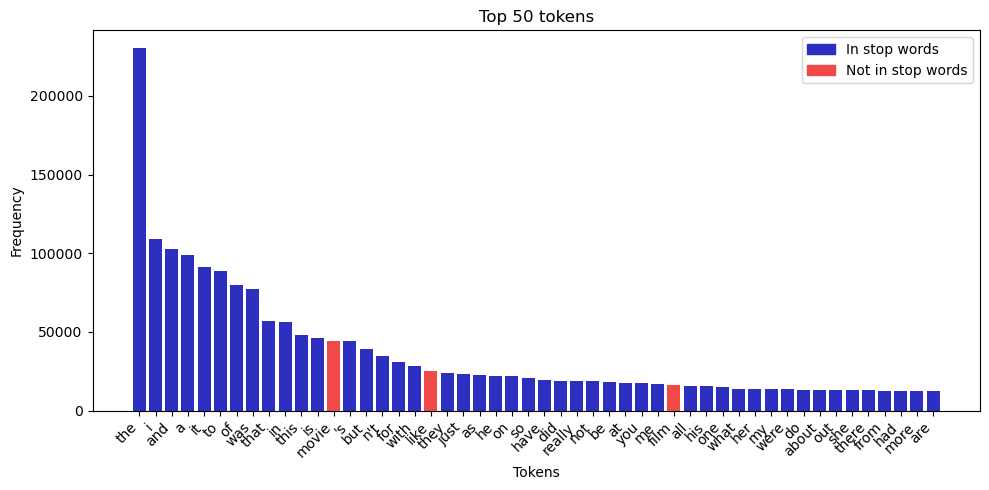

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

top_50_tok = OrderedDict(
    FreqDist(X_train['tokens'].explode()).most_common(50)
    )

tokens = list(top_50_tok.keys())
freq = list(top_50_tok.values())
extra_sw = [t for t in tokens if t not in stopword_list]
ax.bar(x=tokens, height=freq, color=['#f14848' if t in extra_sw else '#2c2fbf' for t in tokens])
ax.set_ylabel('Frequency', size=10)
ax.set_xlabel('Tokens', size=10)
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_title('Top 50 tokens')
custom_bars = [Rectangle((0,0),1,1,color=c, alpha=1) for c in ['#2c2fbf', '#f14848']]
ax.legend(custom_bars, ['In stop words','Not in stop words'], fontsize=10)
fig.set_facecolor('white')
plt.tight_layout()
# plt.savefig('./images/top_50_tokens.png', dpi=500)
plt.show()

The tokens **movie**, **like**, and **film** occur as frequently as many stop words. I'll add them to the stop word list. These words get thrown around so often in r/movies that they probably don't contribute much value in an ML context.

In [23]:
stopword_list.extend(["movie", "like", "film"])

#### Making tokens without stop words:

In [24]:
X_train['tokens_no_sw'] = X_train['tokens'].apply(
    lambda x: [t for t in x if t not in stopword_list]
)

Seeing most frequent tokens without stopwords:

C:\Users\zshoo\AppData\Local\Temp\ipykernel_28120\2080618791.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


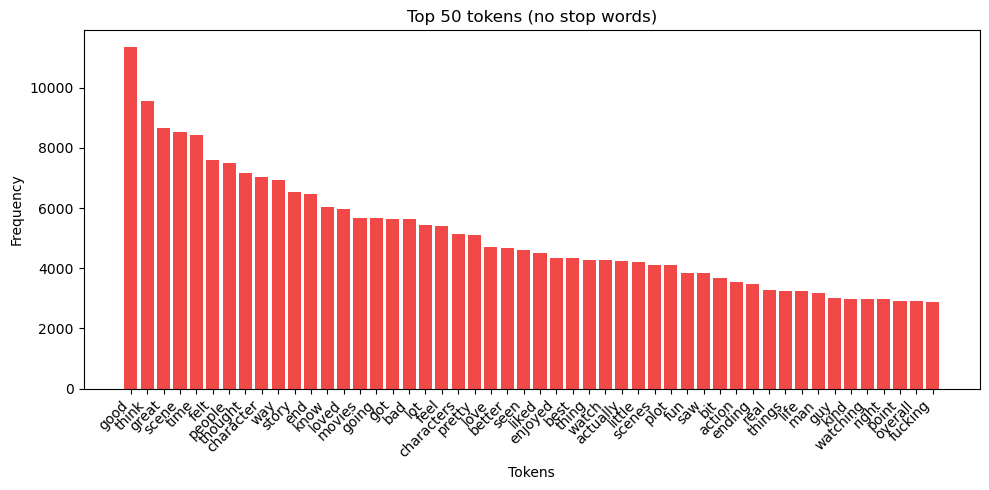

In [25]:
fig, ax = plt.subplots(figsize=(10,5))

top_50_tok = OrderedDict(
    FreqDist(X_train['tokens_no_sw'].explode()).most_common(50)
    )

tokens = list(top_50_tok.keys())
freq = list(top_50_tok.values())
ax.bar(x=tokens, height=freq, color='#f14848')
ax.set_xlabel('Tokens', size=10)
ax.set_ylabel('Frequency', size=10)
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_title('Top 50 tokens (no stop words)')
fig.set_facecolor('white')
plt.tight_layout()
# plt.savefig('./images/top_50_tokens_no_sw.png', dpi=500)
plt.show()

<!-- Interesting that commenters used elipses ("...") often enough that it's in the top 20 tokens. -->

Previewing the resulting features:

In [26]:
X_train.sample(5)

,id,tconst,title,originalTitle,runtimeMinutes,startYear,post_date_utc,post_year,post_month,post_day,genres,numVotes,comments,n_comments,neg_norm,pos_norm,spacy_comments,tokens,tokens_no_sw
10401,p3ztri,tt10366460,coda,CODA,111.0,2021,1.628909e+09,2021,8,13,"Comedy,Drama,Music",124816,[that scene between ruby and frank in the back of their truck as he 'listens' to her sing - what...,100,0.150000,0.690000,"[(that, scene, between, ruby, and, frank, in, the, back, of, their, truck, as, he, ', listens, '...","[that, scene, between, ruby, and, frank, in, the, back, of, their, truck, as, he, listens, to, h...","[scene, ruby, frank, truck, listens, sing, brilliantly, acted, scene, excellent, heartwarming, l..."
62184,5ql91v,tt4385888,20th century women,20th Century Women,119.0,2016,1.485569e+09,2017,1,27,"Comedy,Drama",45583,[i don't think it's possible to watch greta gerwig in anything and not immediately want to be be...,29,0.103448,0.758621,"[(i, do, n't, think, it, 's, possible, to, watch, greta, gerwig, in, anything, and, not, immedia...","[i, do, n't, think, it, 's, possible, to, watch, greta, gerwig, in, anything, and, not, immediat...","[think, possible, watch, greta, gerwig, immediately, want, best, friends, good, small, character..."
13621,nsj230,tt11084896,spirit untamed,Spirit Untamed,88.0,2021,1.622851e+09,2021,6,4,"Adventure,Animation,Comedy",3700,[it's the same plot as every horse girl movie ever made but it looks like the video game that wo...,10,0.300000,0.600000,"[(it, 's, the, same, plot, as, every, horse, girl, movie, ever, made, but, it, looks, like, the,...","[it, 's, the, same, plot, as, every, horse, girl, movie, ever, made, but, it, looks, like, the, ...","[plot, horse, girl, looks, video, game, come, free, straight, dvd, barbie, early, 2000s, dreamwo..."
52723,7llz2i,tt5580390,the shape of water,The Shape of Water,123.0,2017,1.513995e+09,2017,12,22,"Drama,Fantasy,Romance",415698,[theres a thread that pops up here every once in a while about what people think is the best act...,93,0.355556,0.422222,"[(there, s, a, thread, that, pops, up, here, every, once, in, a, while, about, what, people, thi...","[there, s, a, thread, that, pops, up, here, every, once, in, a, while, about, what, people, thin...","[thread, pops, people, think, best, acting, scene, sally, hawkins, scene, begging, giles, help, ..."
43626,9n9qjv,tt6628394,bad times at the el royale,Bad Times at the El Royale,141.0,2018,1.539310e+09,2018,10,11,"Crime,Drama,Mystery",149216,"[""how many people have you killed?"" ""123."" i had no idea he was gonna end up being my favorite c...",99,0.360825,0.453608,"[("", how, many, people, have, you, killed, ?, "", "", 123, ., "", i, had, no, idea, he, was, gon, n...","[how, many, people, have, you, killed, i, had, no, idea, he, was, gon, na, end, up, being, my, f...","[people, killed, idea, gon, na, end, favorite, character, jesus, christ, glad, face, bottle, sma..."


### Further breaking down tokens
#### Lemmatization
Now I want to make a version of these tokenized comments where each word is lemmatized. __Lemmatization__ is a technique that uses grammatical context to convert a word into its root word, or "lemma," which is often its noun form. For example, the tool would change the words "running," "ran," and "runs" into "run."

Essentially I am another tokenizing function, where the output is lemmatized tokens instead of just plain tokens.

In [27]:
def spacy_lemmatize(list_of_docs):
    """
    Takes in a list of SpaCy documents.
    Converts them into one giant list of lemmas as strings.
    Omits punctuation, non-ASCII characters, digits, URLs.
    """
    token_mask = \
        lambda x: all(
            [x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct]
            )
    lemmas_by_doc = [[t.lemma_.lower() for t in doc if token_mask(t)] for doc in list_of_docs]
    lemmas_all_together = list(itertools.chain.from_iterable(lemmas_by_doc))
    return lemmas_all_together

In [28]:
X_train['lemmas'] = \
    X_train['spacy_comments'].apply(spacy_lemmatize)

In [29]:
# Check most common lemmas

FreqDist(X_train['lemmas'].explode()).most_common(20)

[('the', 230062),
 ('be', 220943),
 ('i', 126206),
 ('and', 102878),
 ('a', 99085),
 ('it', 91237),
 ('to', 89996),
 ('of', 79690),
 ('that', 56671),
 ('in', 56066),
 ('not', 54935),
 ('movie', 50186),
 ('this', 48180),
 ('do', 42630),
 ('have', 40367),
 ('but', 39437),
 ('for', 30745),
 ('he', 30259),
 ('like', 30252),
 ('they', 30038)]

#### Lemmatized comments without stop words
In order to make the lemmatized tokens without stop words, I will also need to lemmatize the stop words.

This has to be done to the stop words while they are still within the string because SpaCy uses grammatical context to lemmatize.

In [30]:
stopword_list_lem = []

sw_lem_Series = \
    X_train['spacy_comments'].apply(
        lambda x: [[t.lemma_.lower() for t in doc if t.text.lower() in stopword_list] for doc in x]
    )

sw_lem_Series = sw_lem_Series.apply(lambda x: list(itertools.chain.from_iterable(x)))

for row in sw_lem_Series:
    stopword_list_lem.extend(row)

stopword_list_lem = list(set(stopword_list_lem))

In [31]:
# Lemmatized tokens, excluding stop words

X_train['lemmas_no_sw'] = X_train['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

**Seeing most frequent lemmas without stopwords:**

C:\Users\zshoo\AppData\Local\Temp\ipykernel_28120\1022794854.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


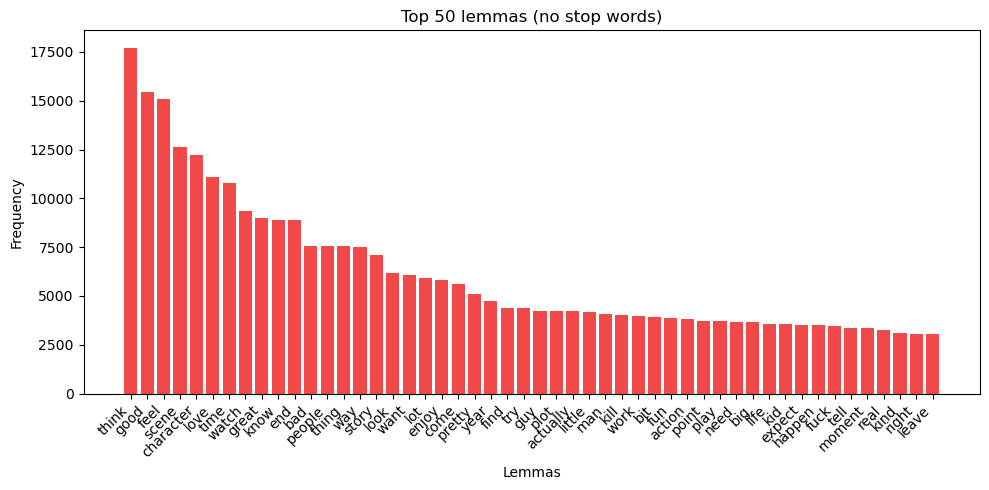

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

top_50_lem = OrderedDict(
    FreqDist(X_train['lemmas_no_sw'].explode()).most_common(50)
    )

tokens = list(top_50_lem.keys())
freq = list(top_50_lem.values())
ax.bar(x=tokens, height=freq, color='#f14848')
ax.set_xlabel('Lemmas', size=10)
ax.set_ylabel('Frequency', size=10)
ax.set_title('Top 50 lemmas (no stop words)')
ax.set_xticklabels(tokens, rotation=45, ha='right')
fig.set_facecolor('white')
plt.tight_layout()
# plt.savefig('./images/top_50_lemmas_no_sw.png', dpi=500)
plt.show()

## Word Clouds<a name="wordclouds"></a>

Artificially giving y_train two classes (for visualization purposes).

1: Above average

0: Below average

In [33]:
y_train_class = y_train.apply(lambda x: int(x > y_train.mean()))
y_train_class.head()

5057     1
2183     1
40719    1
2044     0
67123    0
Name: averageRating, dtype: int64

In [34]:
color_func_0 = get_single_color_func('#f14848')
color_func_1 = get_single_color_func('#2c2fbf')

In [35]:
wc0 = WordCloud(
    max_words=500, 
    random_state=seed, 
    font_path="./font/NotoSans-Regular.ttf", 
    color_func=color_func_0, 
    background_color="rgba(255, 255, 255, 0)", mode="RGBA",
    width=1500,
    height=1000,
    )
wc1 = WordCloud(
    max_words=500, 
    random_state=seed, 
    font_path="./font/NotoSans-Regular.ttf", 
    color_func=color_func_1, 
    background_color="rgba(255, 255, 255, 0)", mode="RGBA",
    width=1500,
    height=1000,
    )

In [36]:
fd_all = FreqDist(X_train['lemmas_no_sw'].explode())
fd_top_50 = [f[0] for f in fd_all.most_common(50)]

In [37]:
fd0 = FreqDist(X_train[y_train_class==0]['lemmas_no_sw'].explode())
fd0 = dict(fd0)

fd1 = FreqDist(X_train[y_train_class==1]['lemmas_no_sw'].explode())
fd1 = dict(fd1)

for lemma in fd_top_50:
    del fd0[lemma]
    del fd1[lemma]

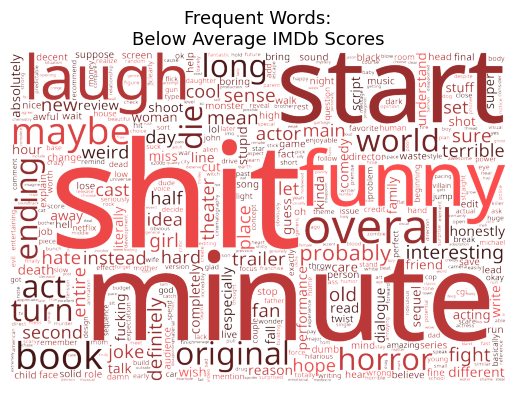

In [38]:
wc0.generate_from_frequencies(fd0)
plt.imshow(wc0)
plt.axis("off")
plt.title('Frequent Words:\nBelow Average IMDb Scores', fontsize=13)
# plt.savefig('./images/word_cloud_0.png', dpi=500, transparent=True)
plt.show()

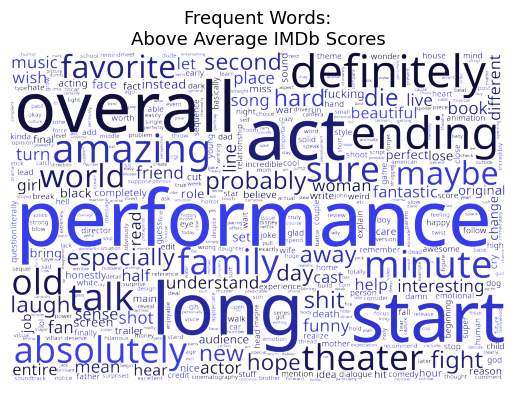

In [39]:
wc1.generate_from_frequencies(fd1)
plt.imshow(wc1)
plt.axis("off")
plt.title('Frequent Words:\nAbove Average IMDb Scores', fontsize=13)
# plt.savefig('./images/word_cloud_1.png', dpi=500, transparent=True)
plt.show()

In [ ]:
# example = X_train[y_train_class==0].explode(column='comments')\
#     .query("comments.str.contains('minute')").sample()

# print(example['title'].iloc[0])
# print(example['comments'].iloc[0])